# Xenium Spatial

## Environment

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import liana as li

## Load data 

In [3]:
# as in https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_xenium.html
adata = sc.read_10x_h5(filename='../../data/xenium_data/cell_feature_matrix.h5')
obs = pd.read_csv('../../data/xenium_data/cells.csv')

In [4]:
obs.set_index(adata.obs_names, inplace=True)
adata.obs = obs.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

## Preprocess

In [5]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [6]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

## Dim Reduction & Visualize

In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Compute connectivity matrix

In [8]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

## Neighbors Enrichment Analysis

In [9]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

100%|██████████| 1000/1000 [00:09<00:00, 103.07/s]


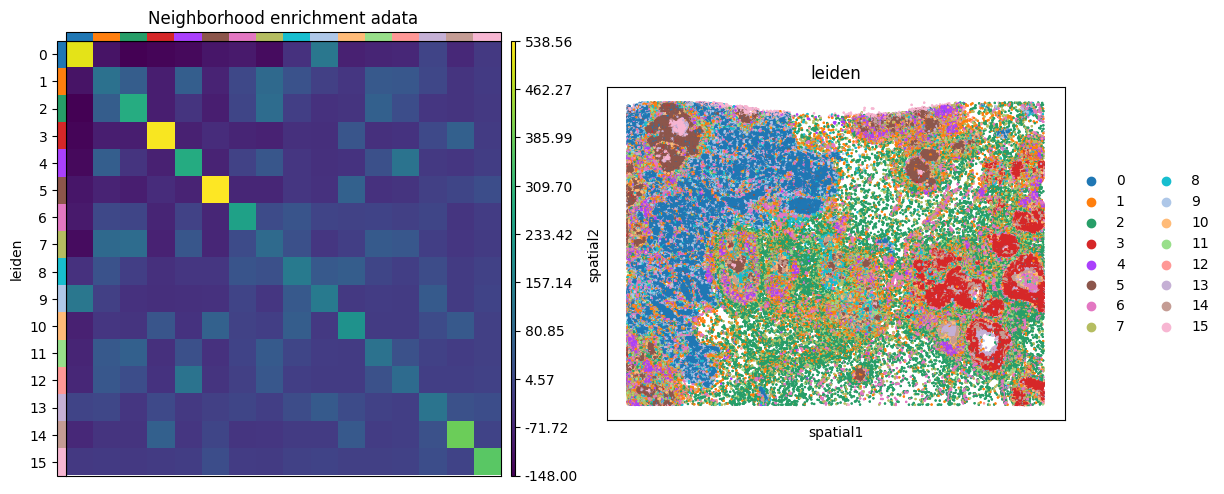

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

## Moran's I (Univariate)

In [11]:
adata_subsample = sc.pp.subsample(adata, fraction=0.5, copy=True)

In [12]:
sq.gr.spatial_autocorr(
    adata_subsample,
    mode="moran",
    n_perms=None,
    n_jobs=1,
)
adata_subsample.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_norm_fdr_bh
KRT7     0.725853        0.0  0.000009               0.0
SCD      0.695204        0.0  0.000009               0.0
EPCAM    0.688698        0.0  0.000009               0.0
FASN     0.671498        0.0  0.000009               0.0
FOXA1    0.669046        0.0  0.000009               0.0
TACSTD2  0.669019        0.0  0.000009               0.0
CEACAM6  0.664590        0.0  0.000009               0.0
KRT8     0.651233        0.0  0.000009               0.0
LUM      0.637320        0.0  0.000009               0.0
ERBB2    0.635715        0.0  0.000009               0.0

## Bivariate Moran's R

In [26]:
li.mt.sp.lr_basis(adata, function_name="morans", use_raw=False,
                  proximity_key="spatial_connectivities",
                  pvalue_method=None, n_perms=100, positive_only=False
                  )

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [16]:
adata.obsp['spatial_connectivities'] = adata.obsp['spatial_connectivities'].astype(np.float32)

In [17]:
adata.uns['global_res']

ligand receptor  ligand_means  ligand_props  receptor_means  \
0      CDH1     EGFR      0.571408      0.497268        0.146387   
1   CEACAM6     EGFR      0.572665      0.421146        0.146387   
2    S100A4     EGFR      0.389653      0.354872        0.146387   
3      MRC1    PTPRC      0.165140      0.156195        0.506102   
5      CD86    CTLA4      0.119952      0.133713        0.078435   
12   S100A4    ERBB2      0.389653      0.354872        1.945219   
13   CXCL12      CD4      0.679917      0.447433        0.410555   
15   CXCL12    CXCR4      0.679917      0.447433        0.649154   
16   CXCL12     SDC4      0.679917      0.447433        0.141917   
17     CCL5     SDC4      0.214817      0.179787        0.141917   
18      PTN     SDC4      0.155855      0.167348        0.141917   
19    MMRN2  CLEC14A      0.068074      0.071067        0.099522   
20    MMRN2     CD93      0.068074      0.071067        0.203453   
21     C1QA     CD93      0.146917      0.159287        0.203453   
22     MMP2   PECAM1      0.431077      0.354579        0.298760   

    receptor_props    interaction  global_r global_pvals  
0         0.187927      CDH1&EGFR -0.066471         None  
1         0.187927   CEACAM6&EGFR  0.004755         None  
2         0.187927    S100A4&EGFR  0.035191         None  
3         0.357500     MRC1&PTPRC  0.132415         None  
5         0.070470     CD86&CTLA4  0.052736         None  
12        0.882030   S100A4&ERBB2 -0.328820         None  
13        0.341079     CXCL12&CD4  0.237083         None  
15        0.490098   CXCL12&CXCR4  0.214419         None  
16        0.215695    CXCL12&SDC4 -0.067587         None  
17        0.215695      CCL5&SDC4 -0.067070         None  
18        0.215695       PTN&SDC4  0.022819         None  
19        0.086963  MMRN2&CLEC14A  0.223258         None  
20        0.184402     MMRN2&CD93  0.233407         None  
21        0.184402      C1QA&CD93  0.066194         None  
22        0.260591    MMP2&PECAM1  0.140159         None

In [18]:
adata.obsm['local_scores']

interaction  CDH1&EGFR  CEACAM6&EGFR  S100A4&EGFR  MRC1&PTPRC  CD86&CTLA4  \
1            -0.000054     -0.000044     0.000027    0.000037   -0.000034   
2             0.000025     -0.000138     0.000058    0.000052    0.000018   
4             0.000057     -0.000004     0.000041    0.000037    0.000013   
5            -0.000007     -0.000066     0.000040    0.000051   -0.000026   
7             0.000037      0.000004     0.000029    0.000029    0.000013   
...                ...           ...          ...         ...         ...   
167776       -0.000048     -0.000117     0.000041    0.000017    0.000013   
167777       -0.000075     -0.000135     0.000046    0.000040    0.000016   
167778       -0.000021     -0.000166     0.000058    0.000048    0.000018   
167779        0.000003     -0.000133     0.000038    0.000044    0.000016   
167780       -0.000037     -0.000123     0.000009    0.000033    0.000013   

interaction  S100A4&ERBB2  CXCL12&CD4  CXCL12&CXCR4  CXCL12&SDC4  CCL5&SDC4  \
1               -0.000066    0.000064      0.000092     0.000055   0.000029   
2               -0.000062    0.000102      0.000129     0.000077   0.000041   
4               -0.000085    0.000073      0.000092     0.000055   0.000029   
5                0.000046    0.000088      0.000147     0.000088   0.000046   
7               -0.000027    0.000053      0.000092     0.000055   0.000029   
...                   ...         ...           ...          ...        ...   
167776          -0.000072   -0.000023      0.000077    -0.000013  -0.000006   
167777          -0.000083    0.000087      0.000110     0.000004   0.000002   
167778          -0.000099    0.000077      0.000124    -0.000110  -0.000061   
167779          -0.000056    0.000087      0.000110    -0.000201  -0.000107   
167780          -0.000016    0.000073      0.000088    -0.000061  -0.000032   

interaction  PTN&SDC4  MMRN2&CLEC14A  MMRN2&CD93  C1QA&CD93  MMP2&PECAM1  
1            0.000027       0.000010    0.000015   0.000024     0.000050  
2            0.000038       0.000014    0.000021   0.000034     0.000070  
4            0.000027       0.000010    0.000015   0.000024     0.000050  
5            0.000044       0.000016    0.000025   0.000039     0.000080  
7            0.000027       0.000010    0.000015   0.000024     0.000050  
...               ...            ...         ...        ...          ...  
167776      -0.000005       0.000003    0.000004   0.000011     0.000044  
167777       0.000002       0.000012    0.000018   0.000029     0.000060  
167778      -0.000050       0.000007    0.000011   0.000023     0.000064  
167779      -0.000076       0.000012    0.000018   0.000025     0.000060  
167780      -0.000023       0.000010    0.000015   0.000024     0.000050  

[164000 rows x 15 columns]

In [19]:
adata.obsm['local_categories']

interaction  CDH1&EGFR  CEACAM6&EGFR  S100A4&EGFR  MRC1&PTPRC  CD86&CTLA4  \
1                    0             0            0           0           0   
2                    0             0            0           0           0   
4                    0             0            0           0           0   
5                    0             0            0           0           0   
7                    0             0            0           0           0   
...                ...           ...          ...         ...         ...   
167776              -1            -1            0           0           0   
167777              -1            -1            0           0           0   
167778              -1            -1            0           0           0   
167779              -1            -1            0           0           0   
167780              -1            -1            0           0           0   

interaction  S100A4&ERBB2  CXCL12&CD4  CXCL12&CXCR4  CXCL12&SDC4  CCL5&SDC4  \
1                       0           0             0            0          0   
2                       0           0             0            0          0   
4                       0           0             0            0          0   
5                       0           0             0            0          0   
7                       0           0             0            0          0   
...                   ...         ...           ...          ...        ...   
167776                 -1           0             0           -1         -1   
167777                 -1           0             0           -1         -1   
167778                 -1           0             0           -1         -1   
167779                 -1           0             0           -1         -1   
167780                 -1           0             0           -1         -1   

interaction  PTN&SDC4  MMRN2&CLEC14A  MMRN2&CD93  C1QA&CD93  MMP2&PECAM1  
1                   0              0           0          0            0  
2                   0              0           0          0            0  
4                   0              0           0          0            0  
5                   0              0           0          0            0  
7                   0              0           0          0            0  
...               ...            ...         ...        ...          ...  
167776             -1              0           0          0            0  
167777             -1              0           0          0            0  
167778             -1              0           0          0            0  
167779             -1              0           0          0            0  
167780             -1              0           0          0            0  

[164000 rows x 15 columns]

In [20]:
lrdata = li.fun.obsm_to_adata(adata, 'local_scores')

In [21]:
lrdata.uns['global_res']

ligand receptor  ligand_means  ligand_props  receptor_means  \
0      CDH1     EGFR      0.571408      0.497268        0.146387   
1   CEACAM6     EGFR      0.572665      0.421146        0.146387   
2    S100A4     EGFR      0.389653      0.354872        0.146387   
3      MRC1    PTPRC      0.165140      0.156195        0.506102   
5      CD86    CTLA4      0.119952      0.133713        0.078435   
12   S100A4    ERBB2      0.389653      0.354872        1.945219   
13   CXCL12      CD4      0.679917      0.447433        0.410555   
15   CXCL12    CXCR4      0.679917      0.447433        0.649154   
16   CXCL12     SDC4      0.679917      0.447433        0.141917   
17     CCL5     SDC4      0.214817      0.179787        0.141917   
18      PTN     SDC4      0.155855      0.167348        0.141917   
19    MMRN2  CLEC14A      0.068074      0.071067        0.099522   
20    MMRN2     CD93      0.068074      0.071067        0.203453   
21     C1QA     CD93      0.146917      0.159287        0.203453   
22     MMP2   PECAM1      0.431077      0.354579        0.298760   

    receptor_props    interaction  global_r global_pvals  
0         0.187927      CDH1&EGFR -0.066471         None  
1         0.187927   CEACAM6&EGFR  0.004755         None  
2         0.187927    S100A4&EGFR  0.035191         None  
3         0.357500     MRC1&PTPRC  0.132415         None  
5         0.070470     CD86&CTLA4  0.052736         None  
12        0.882030   S100A4&ERBB2 -0.328820         None  
13        0.341079     CXCL12&CD4  0.237083         None  
15        0.490098   CXCL12&CXCR4  0.214419         None  
16        0.215695    CXCL12&SDC4 -0.067587         None  
17        0.215695      CCL5&SDC4 -0.067070         None  
18        0.215695       PTN&SDC4  0.022819         None  
19        0.086963  MMRN2&CLEC14A  0.223258         None  
20        0.184402     MMRN2&CD93  0.233407         None  
21        0.184402      C1QA&CD93  0.066194         None  
22        0.260591    MMP2&PECAM1  0.140159         None

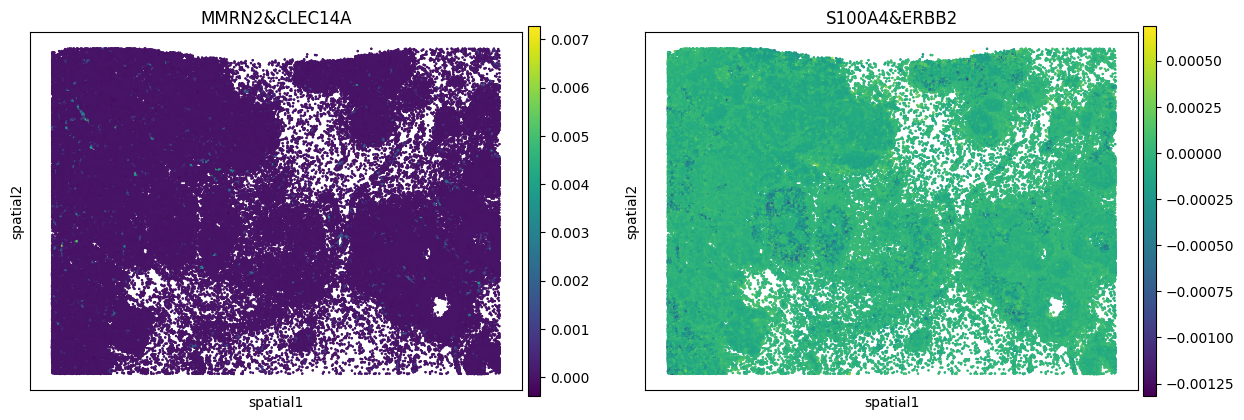

In [22]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "MMRN2&CLEC14A",
        "S100A4&ERBB2",
    ],
    shape=None,
    size=2,
    img=False,
)


## Weighted Pearson

In [27]:
adata.obsp['spatial_connectivities']

<164000x164000 sparse matrix of type '<class 'numpy.float32'>'
	with 983922 stored elements in Compressed Sparse Row format>

In [35]:
li.mt.sp.lr_basis(adata, function_name="pearson", proximity_key="spatial_connectivities", use_raw=False, pvalue_method=None)

In [36]:
lrdata = li.fun.obsm_to_adata(adata, 'local_scores')

In [37]:
lrdata.uns['global_res']

ligand receptor  ligand_means  ligand_props  receptor_means  \
0      CDH1     EGFR      0.571408      0.497268        0.146387   
1   CEACAM6     EGFR      0.572665      0.421146        0.146387   
2    S100A4     EGFR      0.389653      0.354872        0.146387   
3      MRC1    PTPRC      0.165140      0.156195        0.506102   
5      CD86    CTLA4      0.119952      0.133713        0.078435   
12   S100A4    ERBB2      0.389653      0.354872        1.945219   
13   CXCL12      CD4      0.679917      0.447433        0.410555   
15   CXCL12    CXCR4      0.679917      0.447433        0.649154   
16   CXCL12     SDC4      0.679917      0.447433        0.141917   
17     CCL5     SDC4      0.214817      0.179787        0.141917   
18      PTN     SDC4      0.155855      0.167348        0.141917   
19    MMRN2  CLEC14A      0.068074      0.071067        0.099522   
20    MMRN2     CD93      0.068074      0.071067        0.203453   
21     C1QA     CD93      0.146917      0.159287        0.203453   
22     MMP2   PECAM1      0.431077      0.354579        0.298760   

    receptor_props    interaction  global_mean  global_sd  
0         0.187927      CDH1&EGFR     0.004999   0.325439  
1         0.187927   CEACAM6&EGFR    -0.006172   0.328493  
2         0.187927    S100A4&EGFR    -0.016446   0.316664  
3         0.357500     MRC1&PTPRC     0.067751   0.326006  
5         0.070470     CD86&CTLA4    -0.003015   0.202449  
12        0.882030   S100A4&ERBB2    -0.077844   0.418938  
13        0.341079     CXCL12&CD4    -0.016128   0.391434  
15        0.490098   CXCL12&CXCR4    -0.053452   0.408254  
16        0.215695    CXCL12&SDC4    -0.002948   0.306410  
17        0.215695      CCL5&SDC4    -0.012557   0.241559  
18        0.215695       PTN&SDC4     0.006769   0.264614  
19        0.086963  MMRN2&CLEC14A     0.121678   0.315172  
20        0.184402     MMRN2&CD93     0.118743   0.312767  
21        0.184402      C1QA&CD93     0.055787   0.309513  
22        0.260591    MMP2&PECAM1     0.018945   0.379270

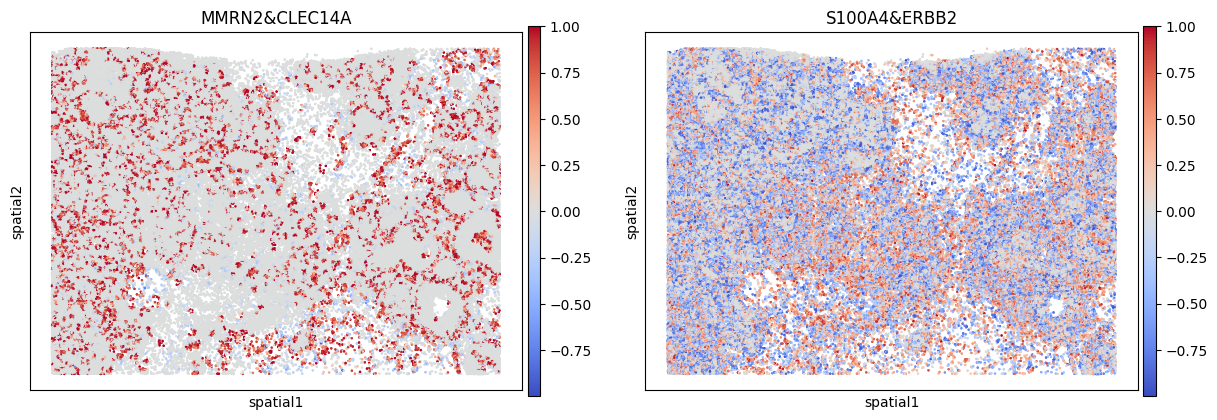

In [38]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "MMRN2&CLEC14A",
        "S100A4&ERBB2",
    ],
    shape=None,
    size=2,
    img=False,
    cmap='coolwarm'
)


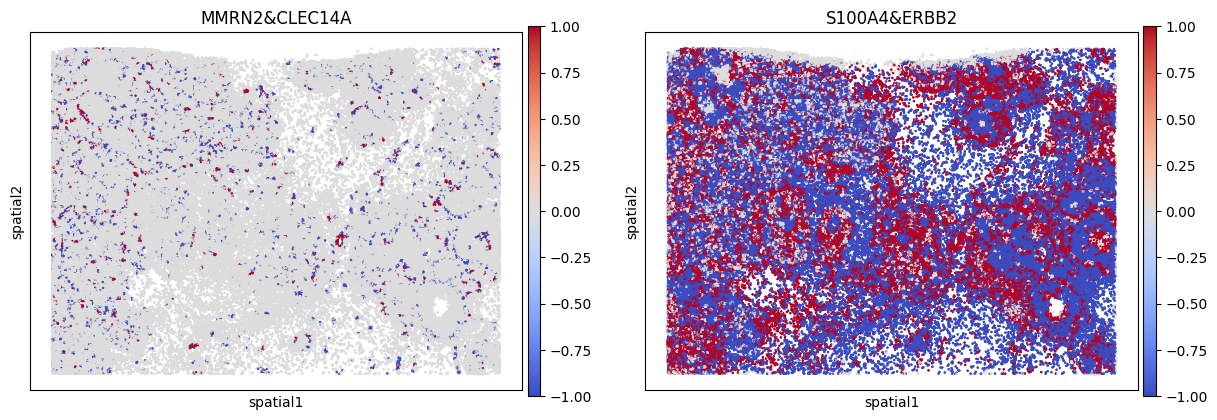

In [33]:
lrcats = li.fun.obsm_to_adata(adata, 'local_categories')
sq.pl.spatial_scatter(
    lrcats,
    library_id="spatial",
    color=[
        "MMRN2&CLEC14A",
        "S100A4&ERBB2",
    ],
    shape=None,
    size=2,
    img=False,
    cmap='coolwarm'
)


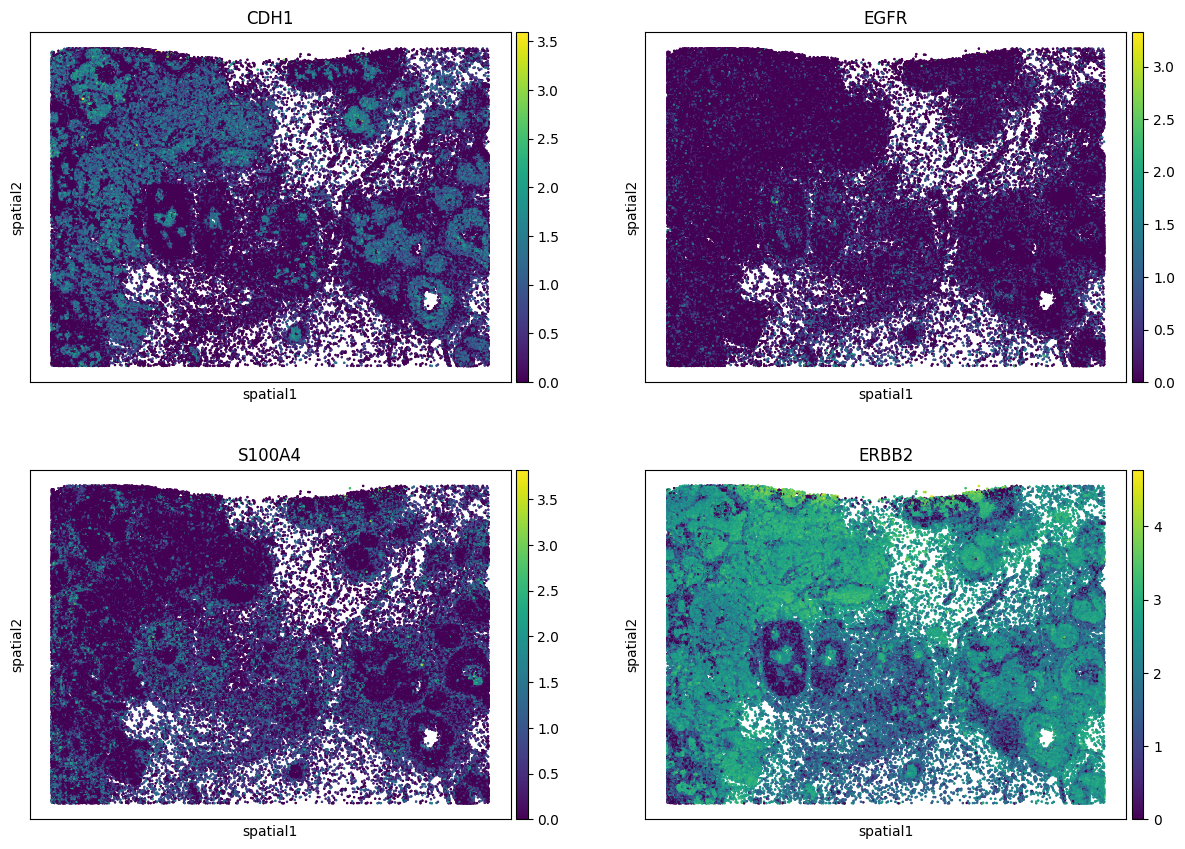

In [32]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "CDH1",
        "EGFR",
        "S100A4",
        "ERBB2"
    ],
    shape=None,
    size=2,
    img=False,
    ncols=2
)
